In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2016,7,25)
timeStart = datetime.datetime(2016,7,25,3,0)
timeEnd = datetime.datetime(2016,7,25,7,0)
sapsTime = datetime.datetime(2016,7,25,5,30)
sapsRadList = [ "cvw", "cve","fhw",\
               "fhe", "bks", "wal" ]
selBeam = 7
sapsMlatRange = [ 52., 63. ]#[ 56., 60. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 0 # per radar per beam
velScale = [ -500, 500 ]
velMagnScale = [ 0, 1500 ]
coords="mag"
# TEC variables
tecScale = [ 0, 10 ]

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

In [4]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-vps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF["velMagn"] = numpy.abs(velsDF["vLos"])
velsDF.head()

dateStr  timeStr  beam  range  azimCalcMag    vLos    power   spwdth  \
0  20160725      200     0      0     -31.8579  0.0000  11.3374  37.2005   
1  20160725      200     0      1     -35.2038  0.0000  11.3374  46.0231   
2  20160725      200     0      2     -37.7155  3.5175   8.9233  78.2254   
3  20160725      200     0      3     -39.7328  6.5212   8.5291  46.0231   
4  20160725      200     0      4     -41.4199  3.6386   8.9351  34.0043   

      MLAT      MLON      MLT     GLAT      GLON  radId radCode  \
0  38.6897 -146.2574  11.4109  43.7946  142.2906     41     hkw   
1  39.0370 -146.7567  11.3776  44.1381  141.7370     41     hkw   
2  39.3297 -147.2205  11.3467  44.4252  141.2232     41     hkw   
3  39.6014 -147.6740  11.3165  44.6902  140.7215     41     hkw   
4  39.8590 -148.1218  11.2866  44.9400  140.2269     41     hkw   

                 date  normMLT  velMagn  
0 2016-07-25 02:00:00  11.4109   0.0000  
1 2016-07-25 02:00:00  11.3776   0.0000  
2 2016-07-25 02:00:00  11.3467   3.5175  
3 2016-07-25 02:00:00  11.3165   6.5212  
4 2016-07-25 02:00:00  11.2866   3.6386

In [5]:
# read from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF = lshellDF[ (lshellDF["velSAPS"] > 0.) &\
                    (lshellDF["velSAPS"] < 2000.) ].reset_index(drop=True)
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )
lshellDF.head()

azimSAPS   azimSTD  delMLT  goodFit  mlat  normMlt     velSAPS     velSTD  \
0  -3.236139  1.387087     0.5     True  62.0     -5.0  646.002636  43.323736   
1  -5.878198  2.760037     1.5     True  61.0     -4.0  620.821279  57.591342   
2  -8.114615  3.692693     1.5     True  61.5     -5.0  514.861281  62.939880   
3  -6.618126  1.352016     1.0     True  61.0     -5.0  422.839892  19.427486   
4 -11.870053  2.809972     1.0     True  61.0     -3.0  749.034029  65.355440   

   endPtMLAT  endPtNormMLT                date  endPtmlat  endPtnormMlt  Mlon  \
0      62.04         -5.64 2016-07-25 04:06:00      62.04         -5.64 -63.0   
1      61.06         -4.62 2016-07-25 04:06:00      61.06         -4.62 -48.0   
2      61.57         -5.51 2016-07-25 04:06:00      61.57         -5.51 -63.0   
3      61.05         -5.42 2016-07-25 04:06:00      61.05         -5.42 -63.0   
4      61.15         -3.73 2016-07-25 04:06:00      61.15         -3.73 -33.0   

   EndptMlon  
0      -72.0  
1      -57.0  
2      -70.0  
3      -69.0  
4      -44.0

In [6]:
# read TEC data from the feather file
tecDF = feather.read_dataframe('../data/tec-mf-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
tecDF.head()

dateStr  timeStr  Mlat  Mlon  med_tec  dlat  dlon                date  \
0  20160725      200  11.0   0.0      3.1   1.0   2.0 2016-07-25 02:00:00   
1  20160725      200  11.0   2.0      2.7   1.0   2.0 2016-07-25 02:00:00   
2  20160725      200  11.0   4.0      2.3   1.0   2.0 2016-07-25 02:00:00   
3  20160725      200  11.0   6.0      2.7   1.0   2.0 2016-07-25 02:00:00   
4  20160725      200  11.0   8.0      2.7   1.0   2.0 2016-07-25 02:00:00   

         MLT  
0  21.165544  
1  21.298877  
2  21.432210  
3  21.565544  
4  21.698877

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


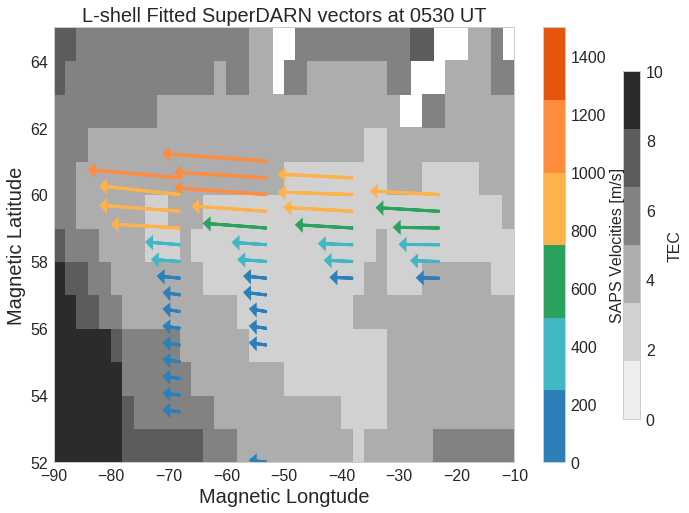

In [7]:
selSapsDF = lshellDF[ lshellDF["date"] == sapsTime ]
selSapsDF["SAPS speed [m/s]"] = selSapsDF["velSAPS"]
plotMLTends = selSapsDF['EndptMlon'].tolist()
plotmlatends = selSapsDF['endPtmlat'].tolist()
plotMLTbegins = selSapsDF['Mlon'].tolist()
plotmlatbegins = selSapsDF['mlat'].tolist()
plotVelMagns = selSapsDF['SAPS speed [m/s]'].tolist()


# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# set colorbar
tecSeaMap = ListedColormap(sns.color_palette("Greys"))
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# lshlPlt = selSapsDF.plot( kind='scatter',
#               x='Mlon',
#               y='mlat',
#               c='SAPS speed [m/s]',
#               s=1., cmap=seaMap, vmin=velMagnScale[0],\
#               vmax=velMagnScale[1], ax=ax,fontsize=20)
lshellPlot = ax.scatter( x=selSapsDF["Mlon"], y=selSapsDF["mlat"],\
                     c=selSapsDF["SAPS speed [m/s]"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        if currMLTbgn <= currMLTend:
            print currMLTbgn, currMLTend
#         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                 head_width=0.25, head_length=0.75, fc=currCol, ec=currCol, lw=3.)
# PLOT TEC Values
# get the closest times where we have TEC data
minDT = 1e3
closestDate = None
for tt in tecDF["date"].unique():
    ts = (tt - numpy.datetime64('1970-01-01T00:00:00Z')) / numpy.timedelta64(1, 's')
    dt = datetime.datetime.utcfromtimestamp(ts)
    delDT = (dt-sapsTime).total_seconds()
    if abs(delDT) < abs(minDT):
        closestDate = tt
        minDT = delDT
selTecDF = tecDF[ tecDF["date"] == closestDate ].reset_index(drop=True)
selTecDF["Mlon2"] = [x-360 if x>180 else x for x in selTecDF["Mlon"] ]
plotTecDF = selTecDF[ ["Mlon2", "Mlat",\
                        "med_tec"] ].pivot( "Mlon2", "Mlat" )

mltVals = plotTecDF.index.values
mlatVals = plotTecDF.columns.levels[1].values

mltCntr, mlatCntr  = numpy.meshgrid( mltVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
medFTecVals = numpy.ma.masked_where(\
                numpy.isnan(plotTecDF["med_tec"].values),\
                plotTecDF["med_tec"].values)
tecPlot = ax.pcolormesh(mltCntr.T , mlatCntr.T, medFTecVals,\
                        cmap=tecSeaMap, vmin=tecScale[0],\
                        vmax=tecScale[1])

cbar = plt.colorbar(tecPlot, orientation='vertical',\
                    shrink=0.8, pad=-0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('TEC', fontsize=16)
# PLOT TEC Values

ax.set_xlim( [-90,-10] )
ax.set_ylim( [ 52., 65. ] )
ax.set_ylabel( "Magnetic Latitude", fontsize=20 )
ax.set_xlabel( "Magnetic Longtude", fontsize=20 )
ax.set_title("L-shell Fitted SuperDARN vectors at " +\
             sapsTime.strftime("%H%M") + " UT", fontsize=20)

ax.tick_params(labelsize=16)
cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(lshellPlot, cax=cax, orientation='horizontal')


f.savefig("../plots/lshell-tec-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

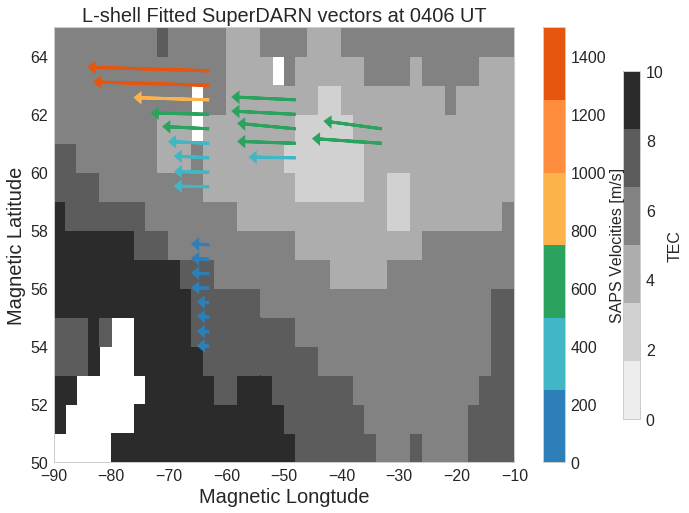

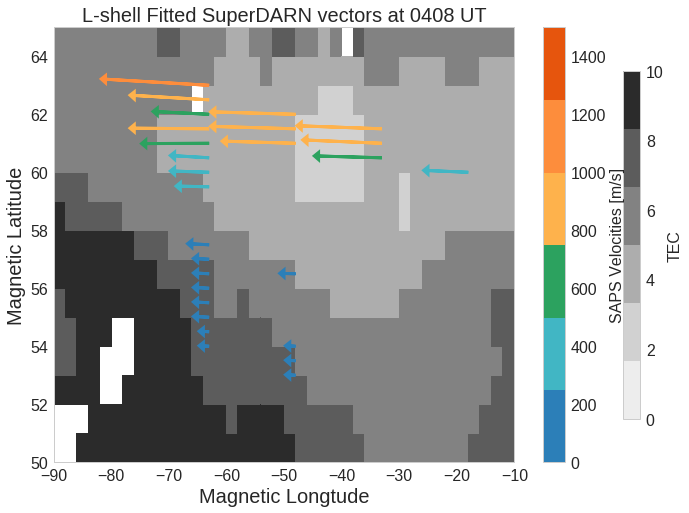

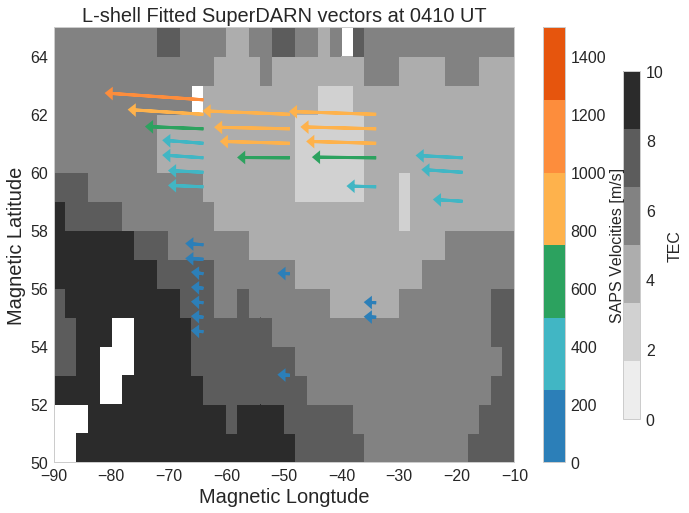

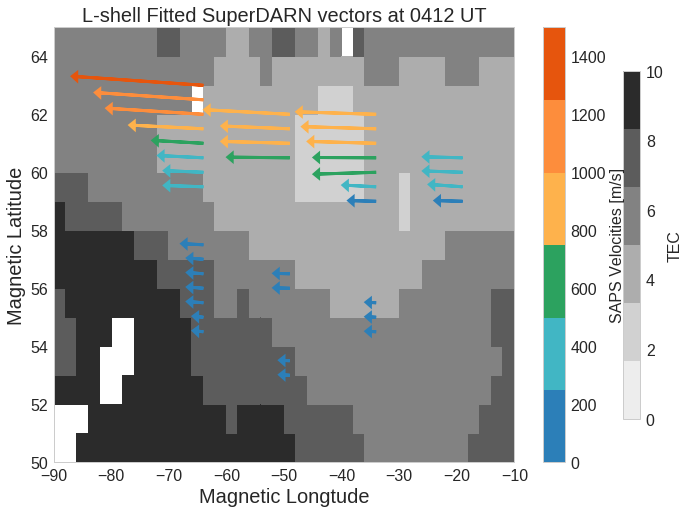

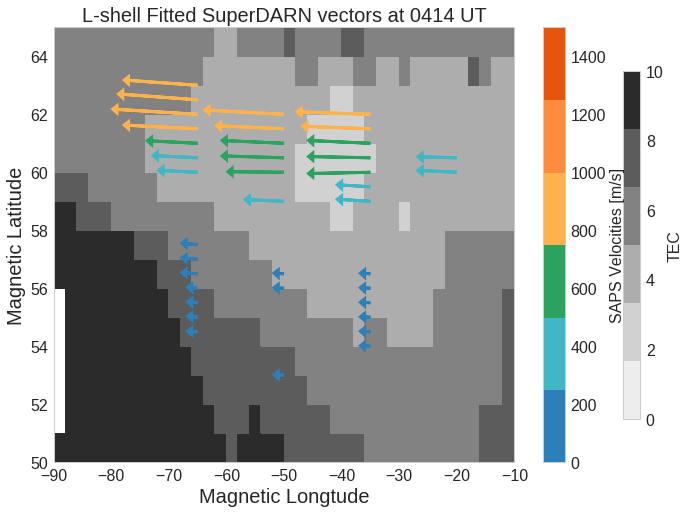

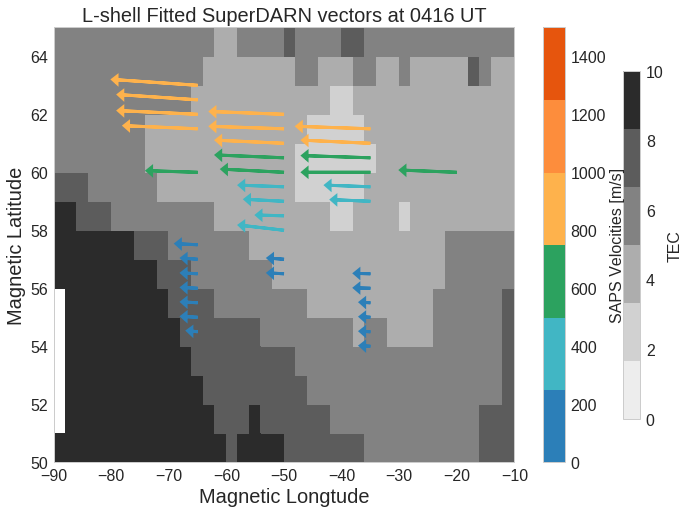

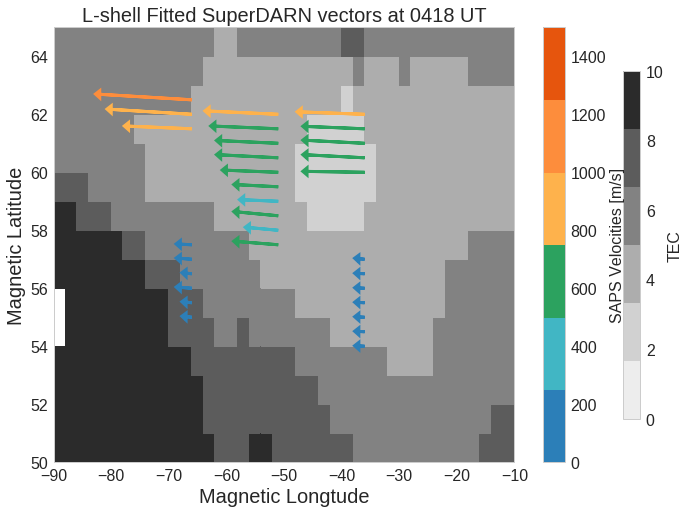

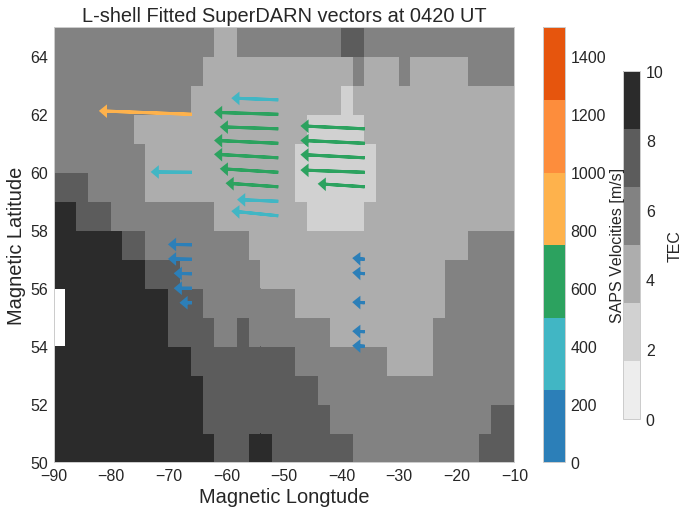

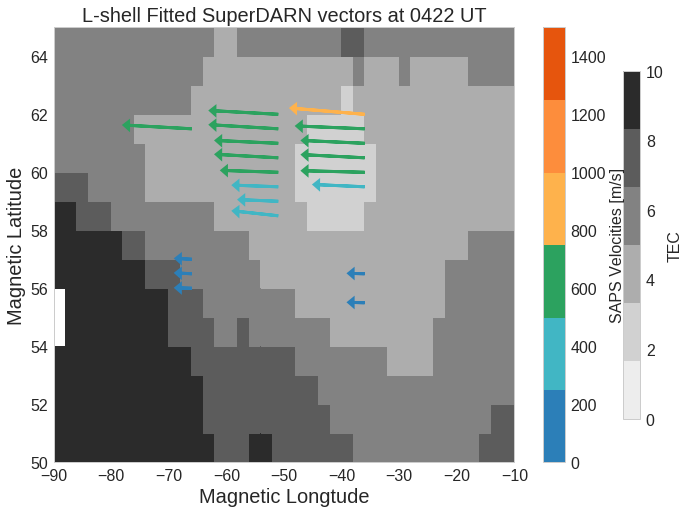

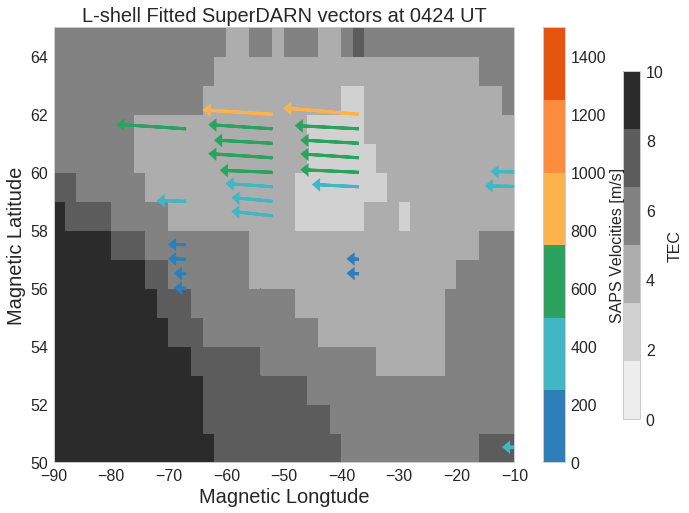

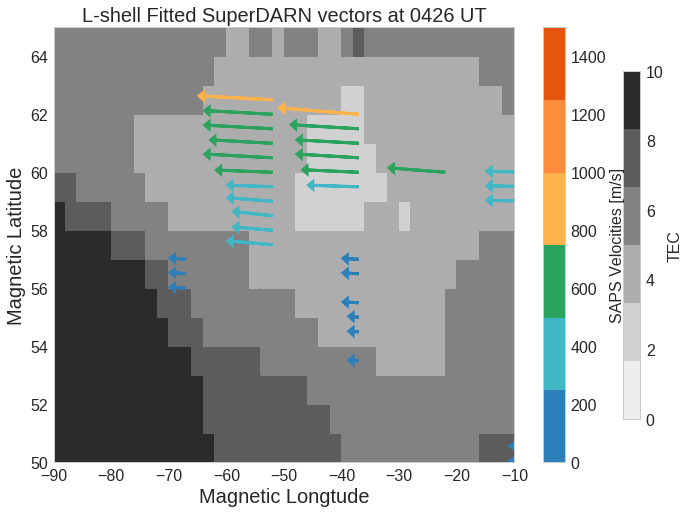

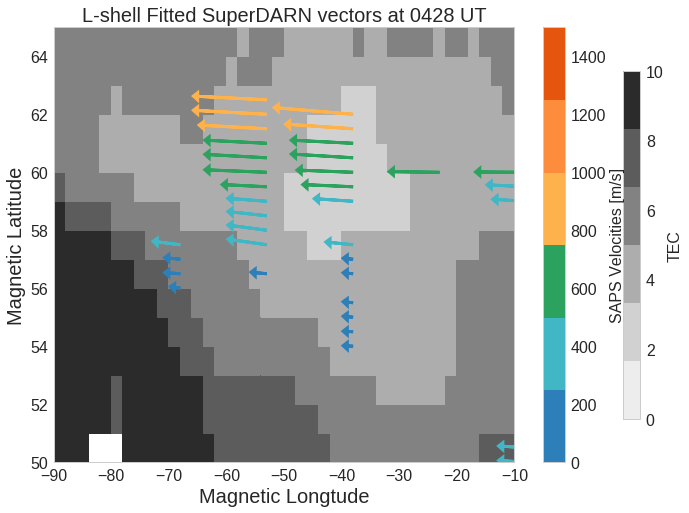

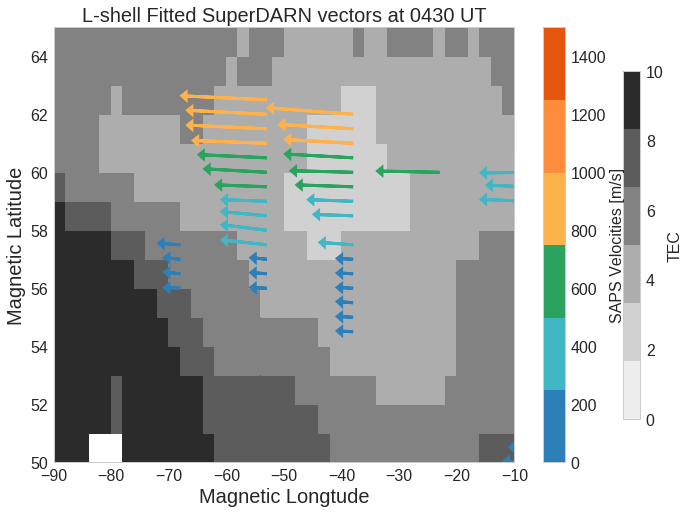

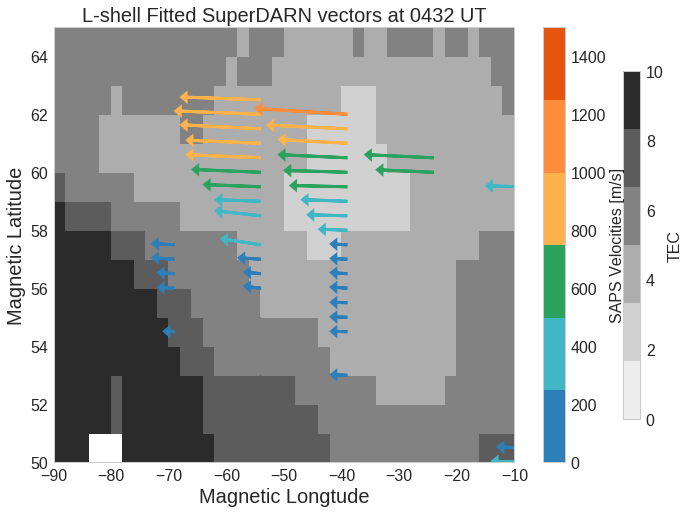

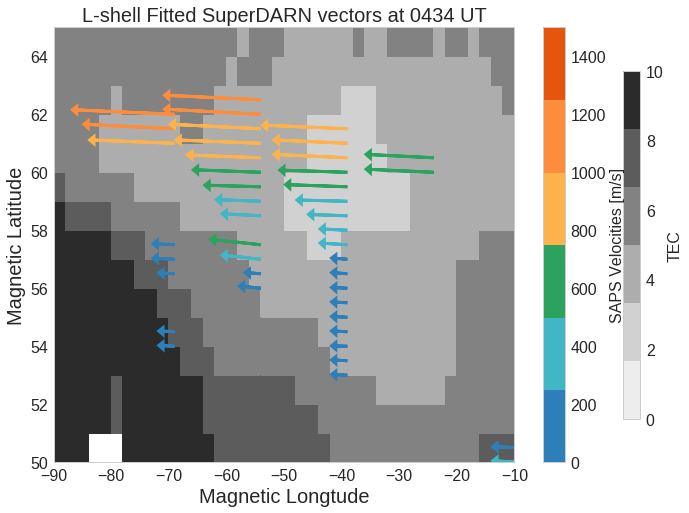

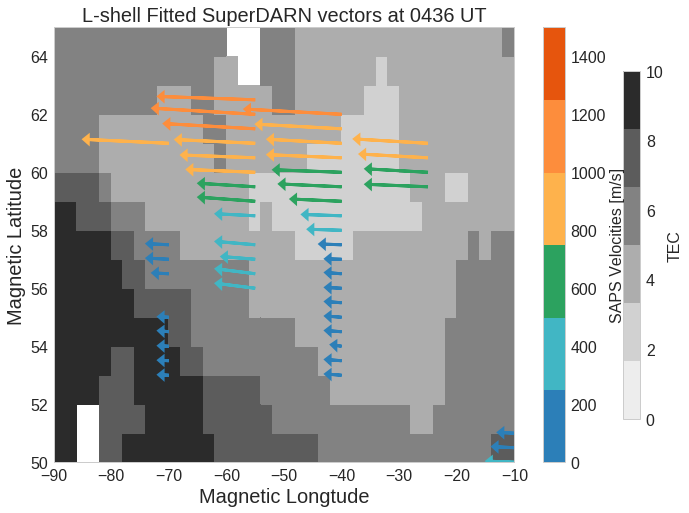

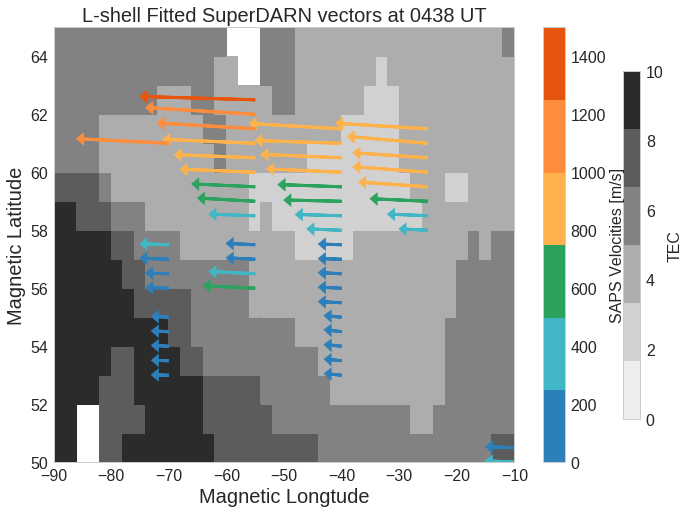

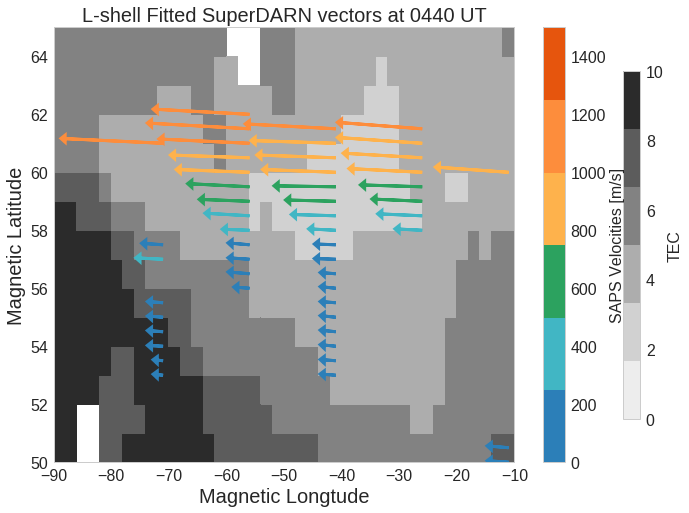

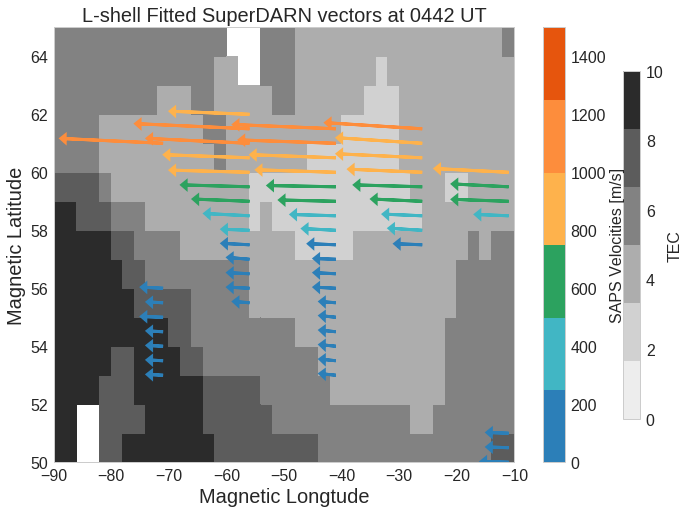

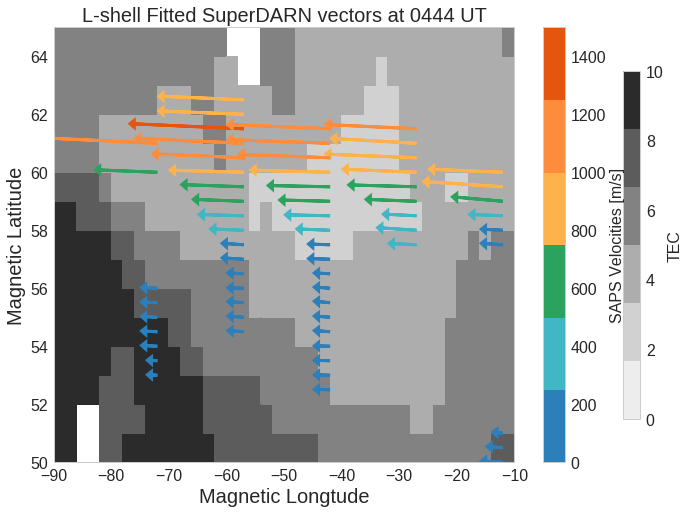

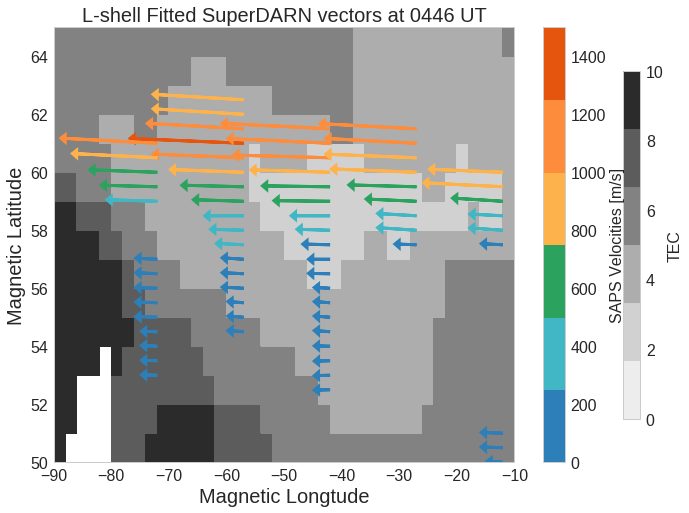

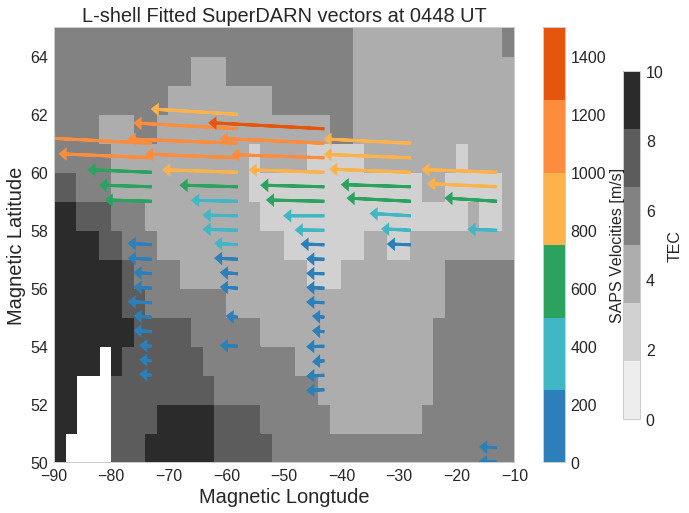

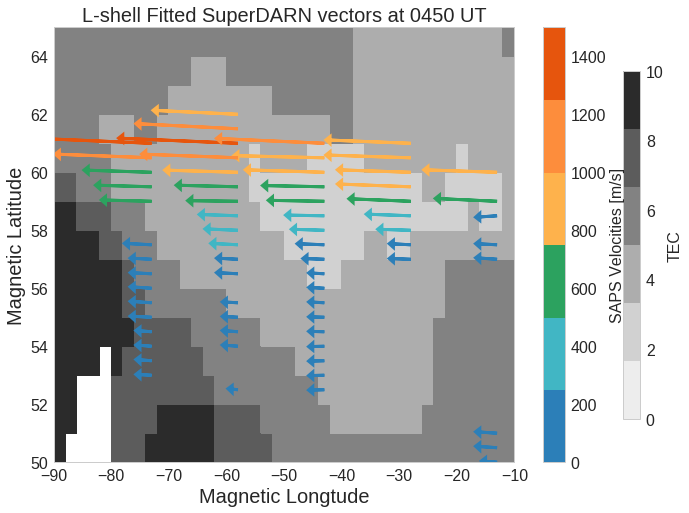

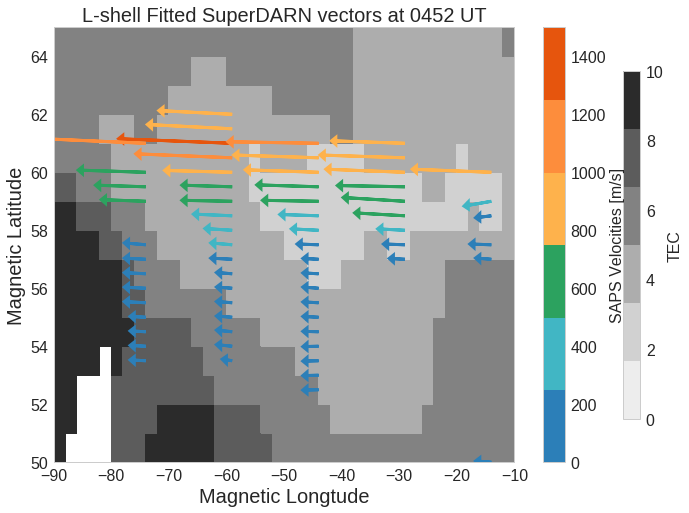

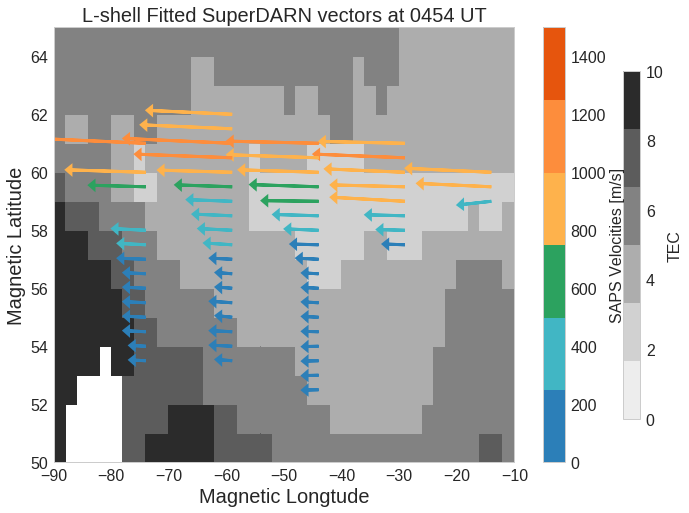

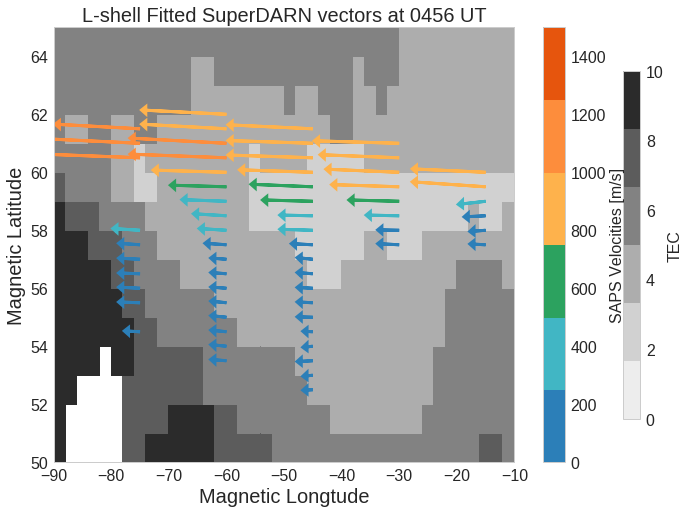

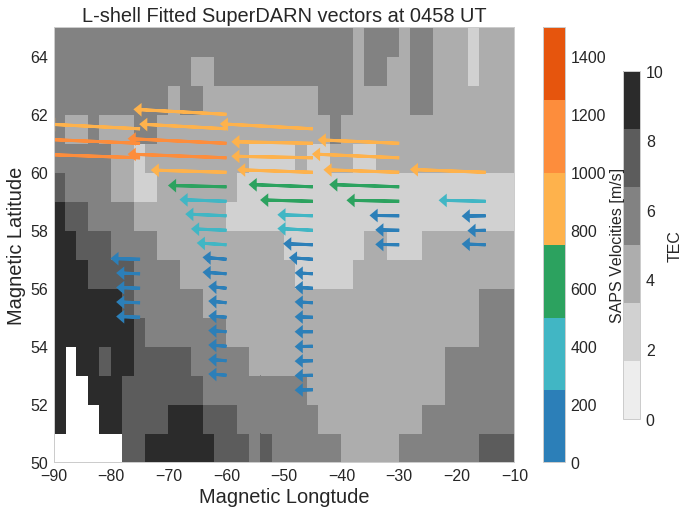

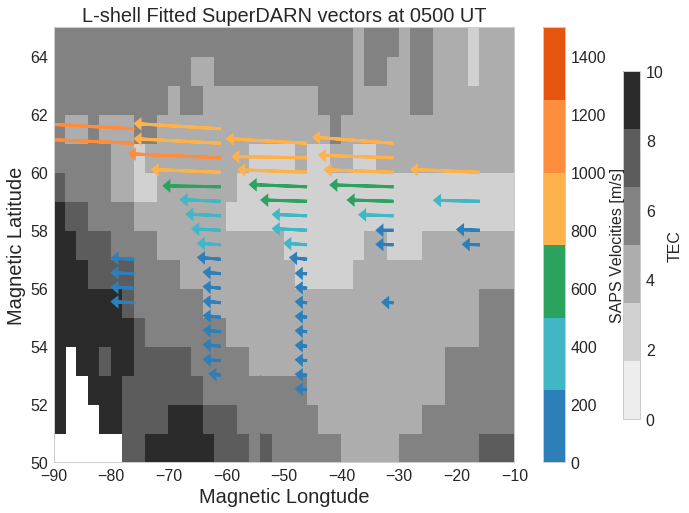

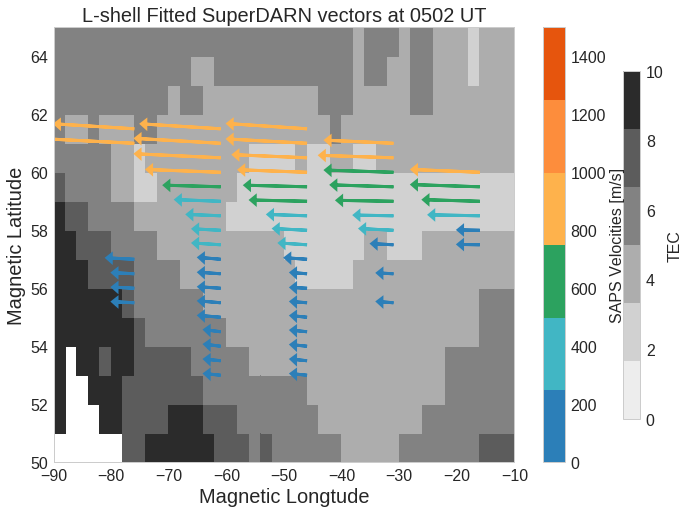

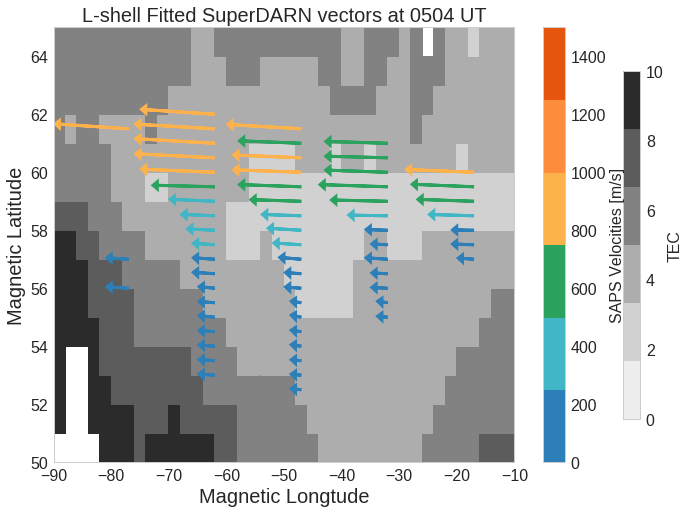

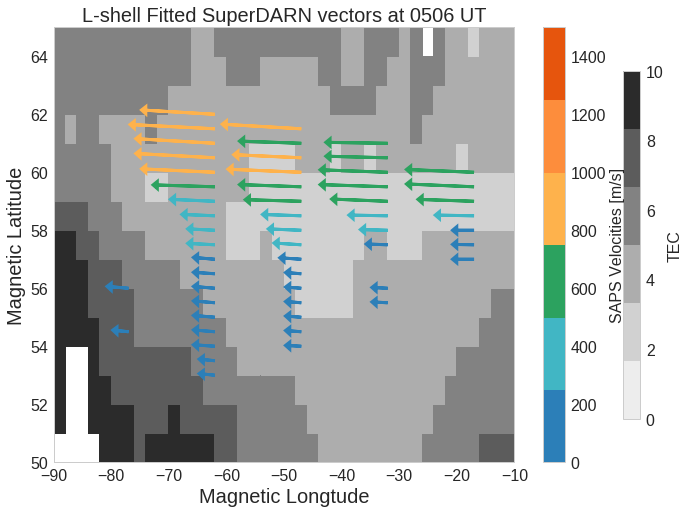

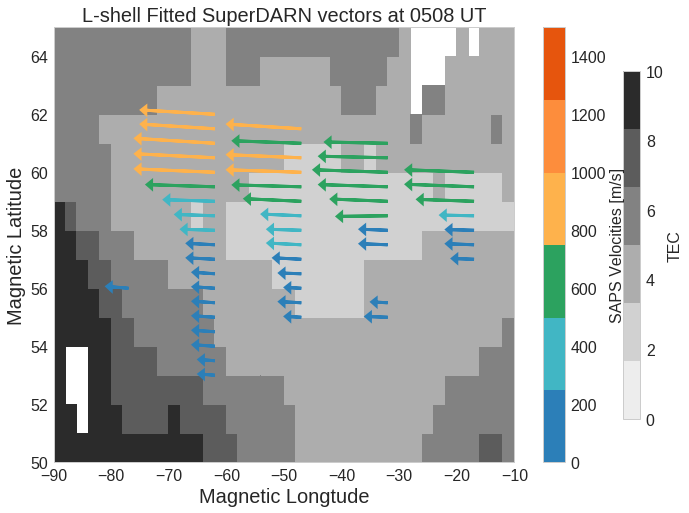

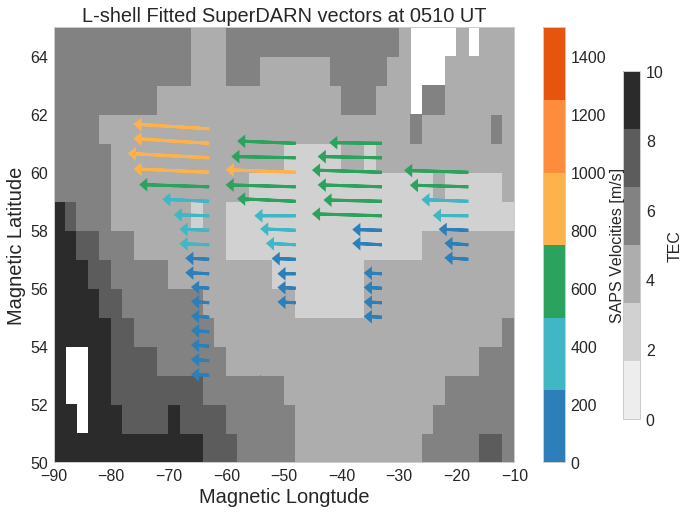

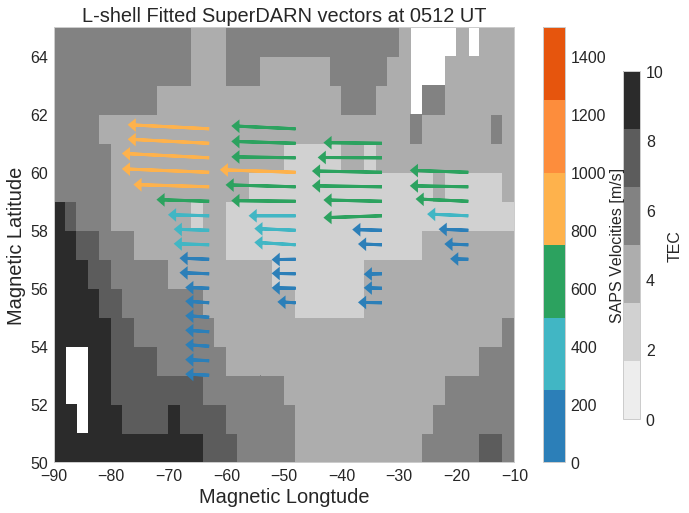

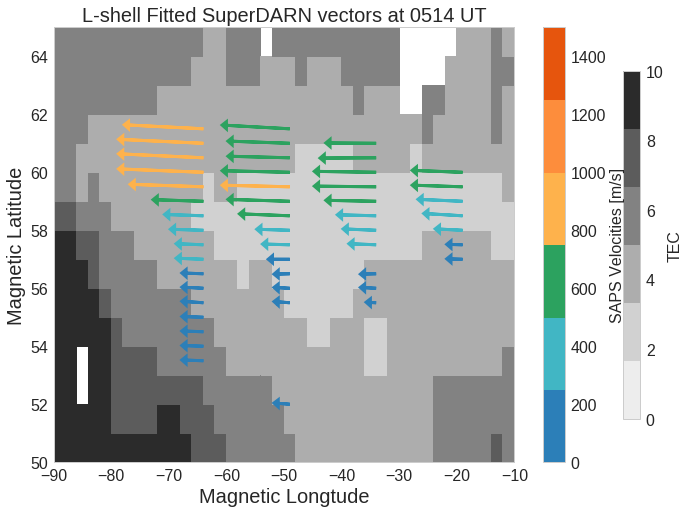

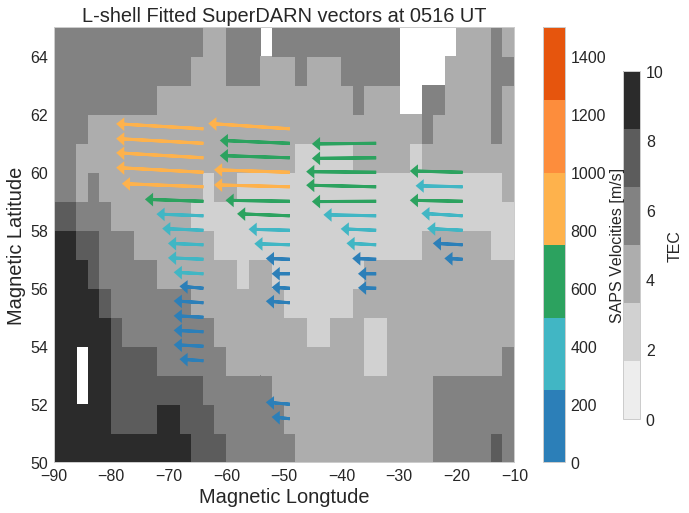

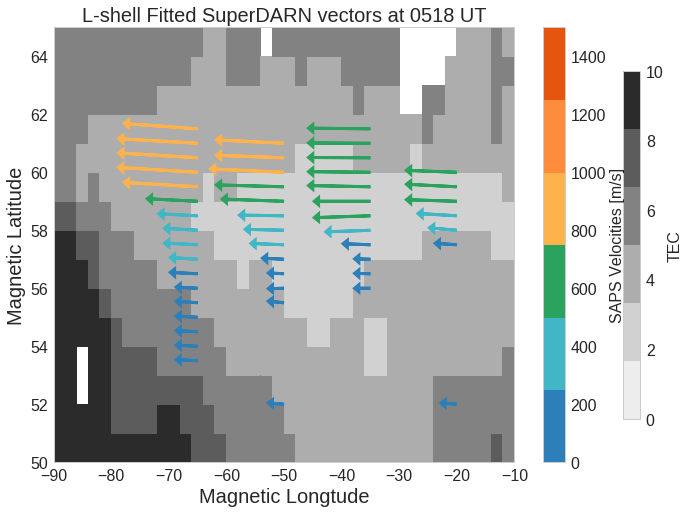

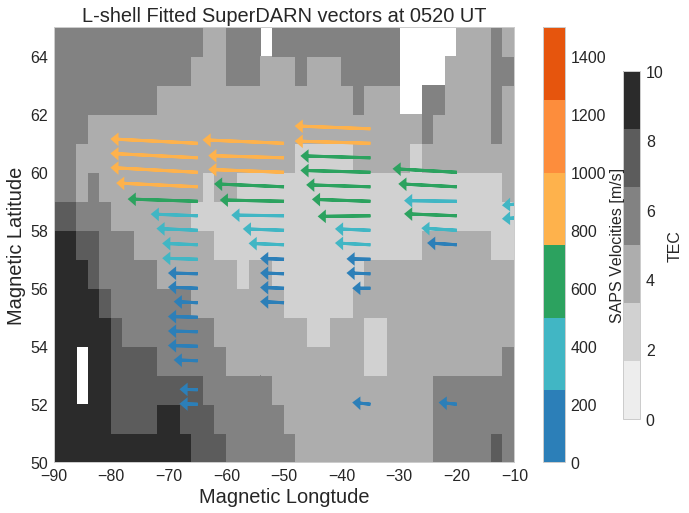

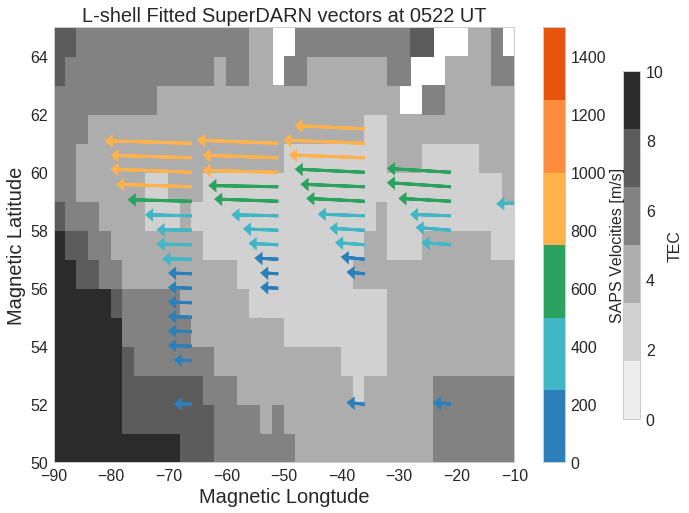

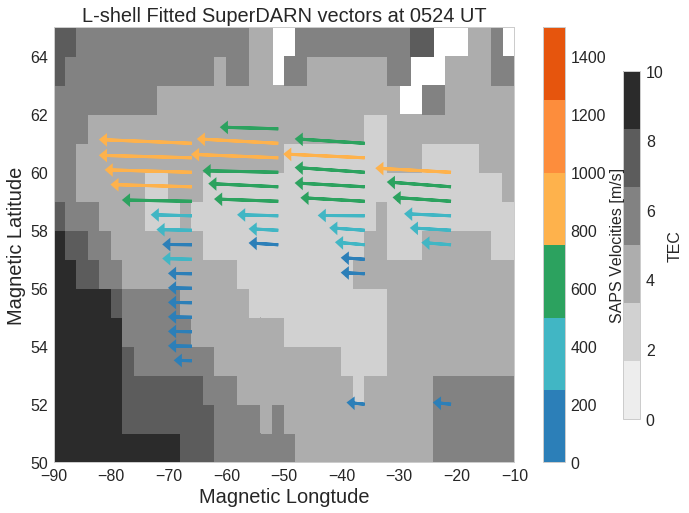

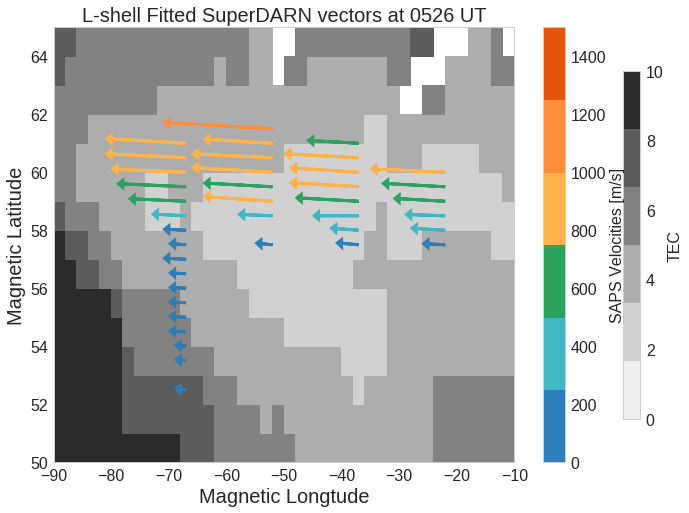

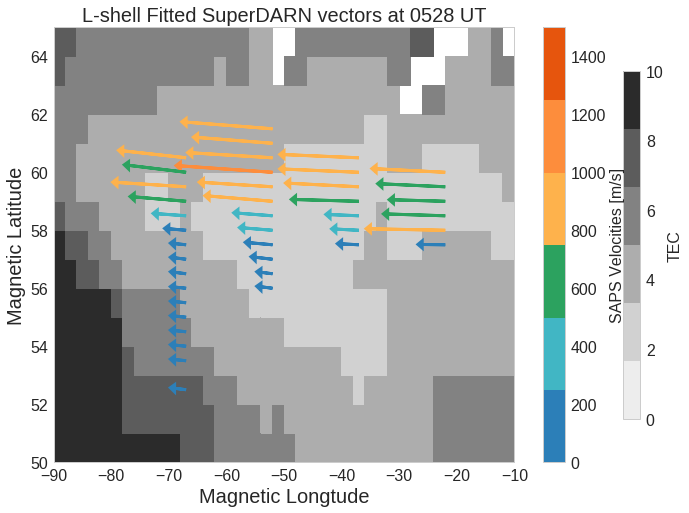

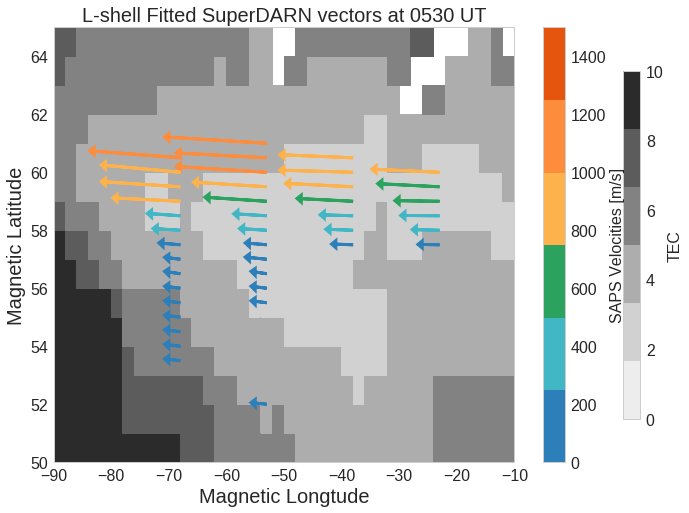

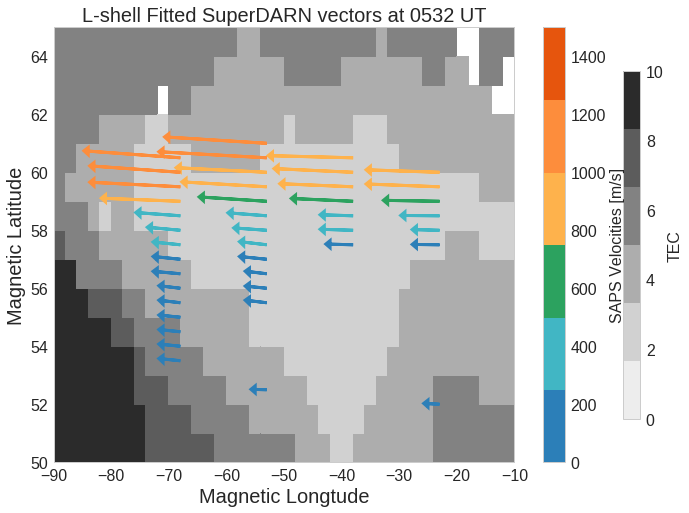

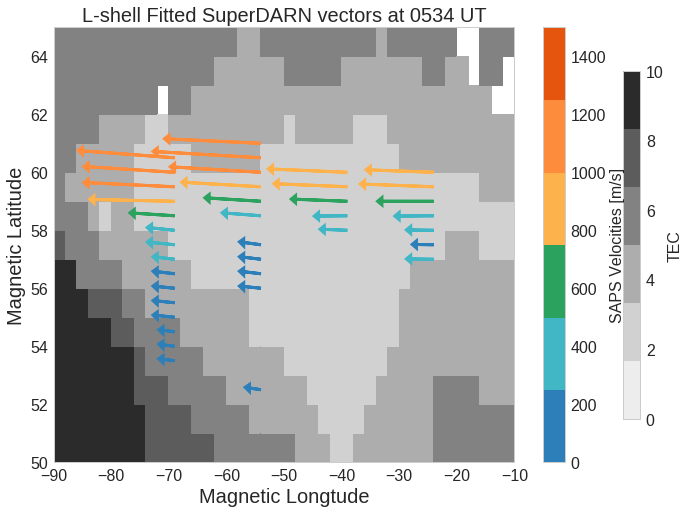

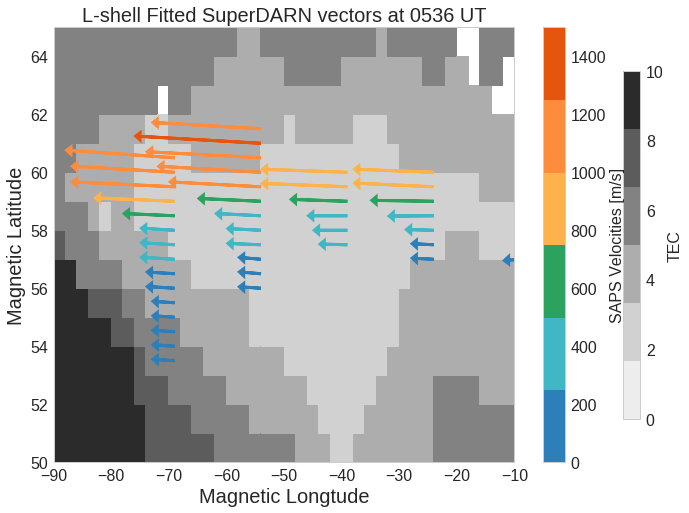

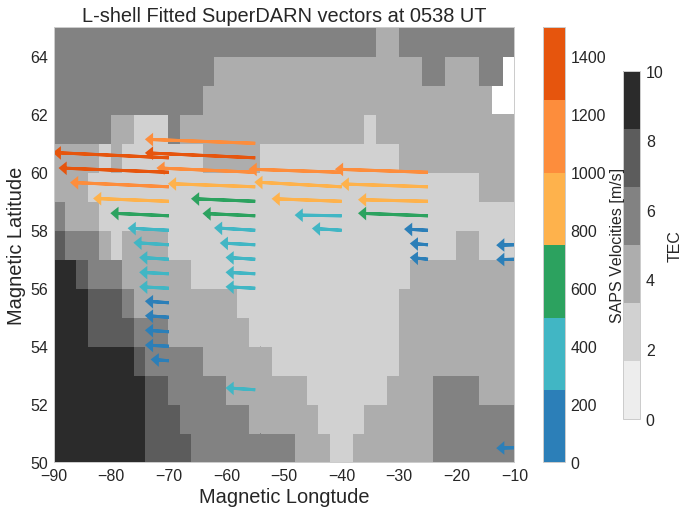

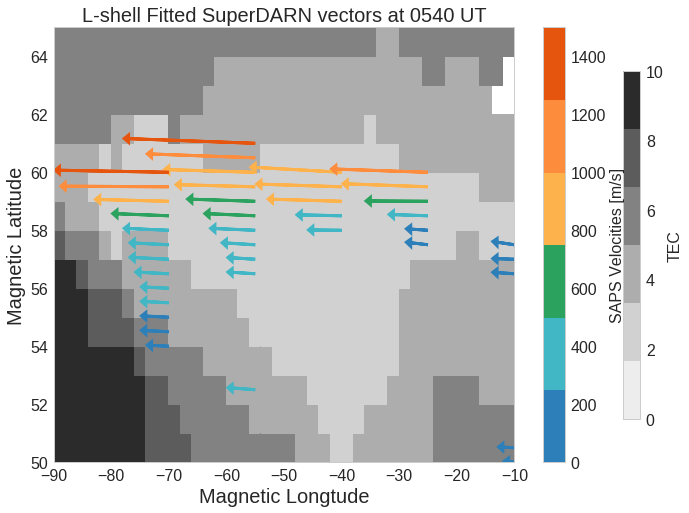

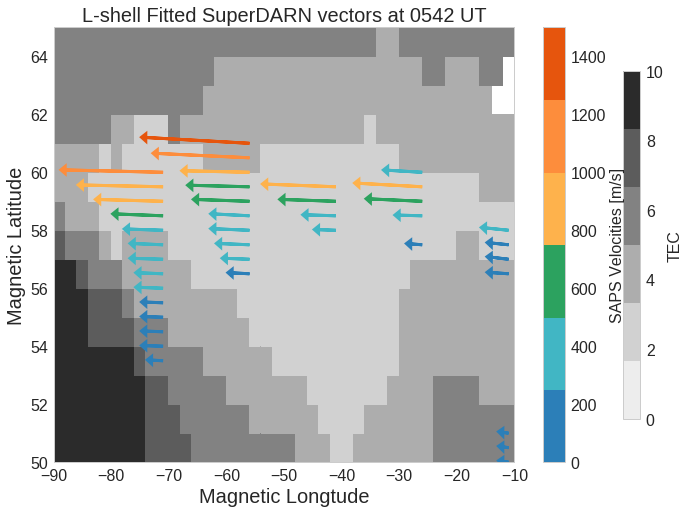

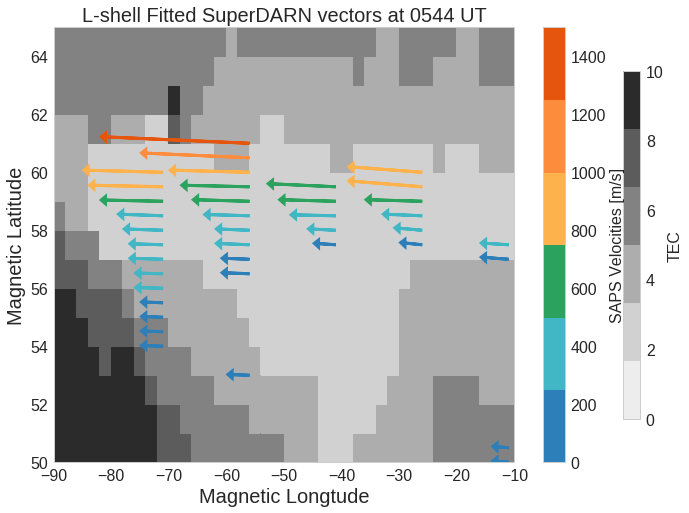

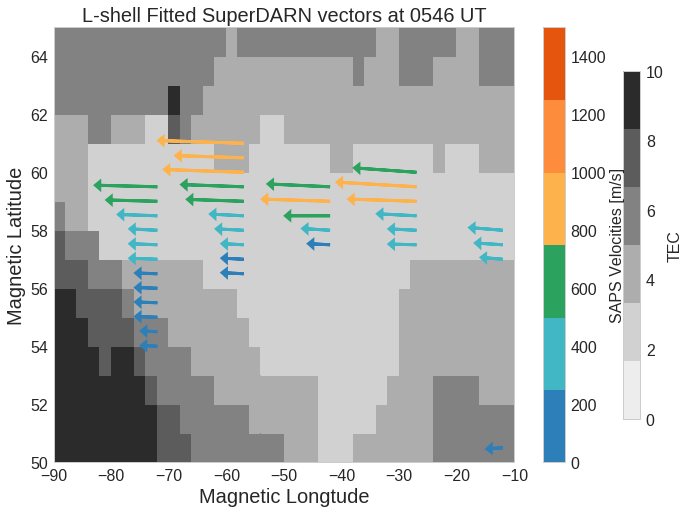

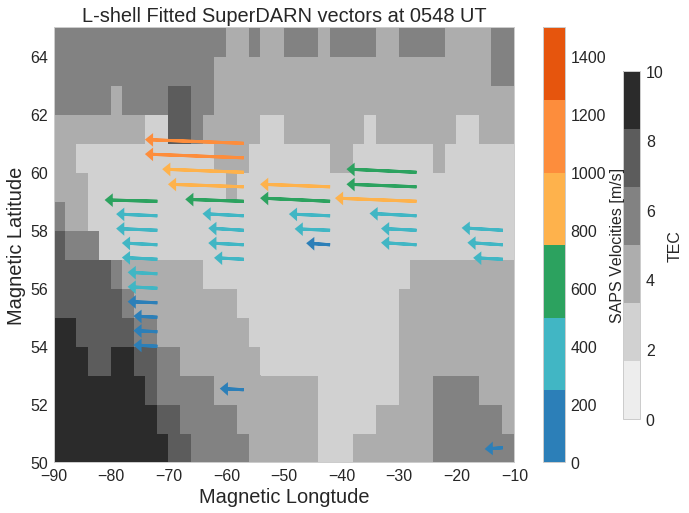

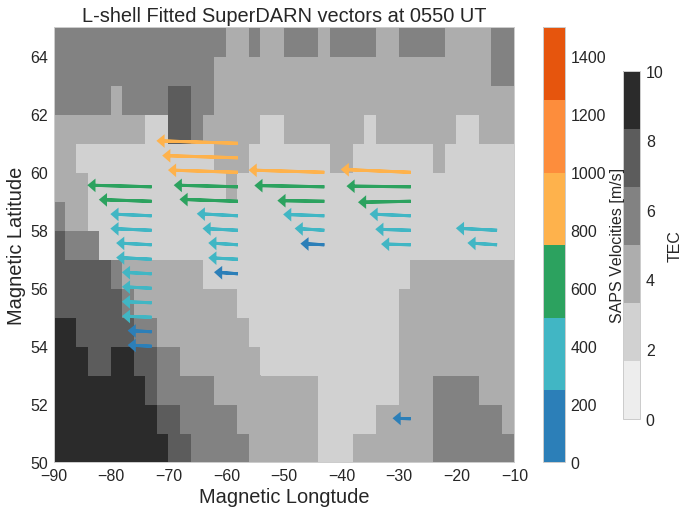

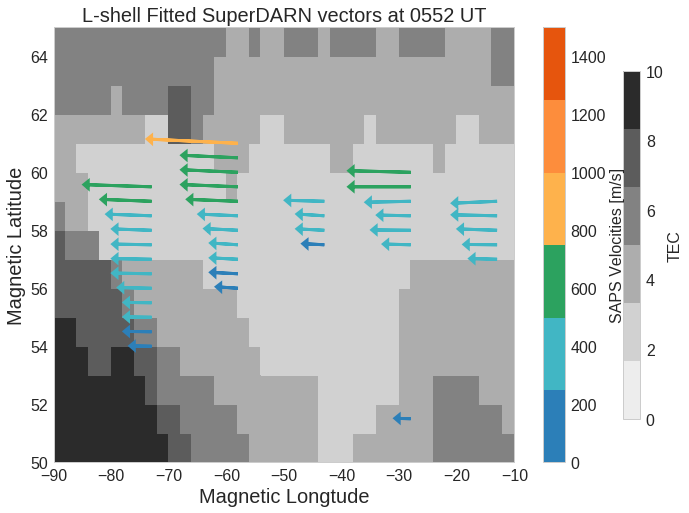

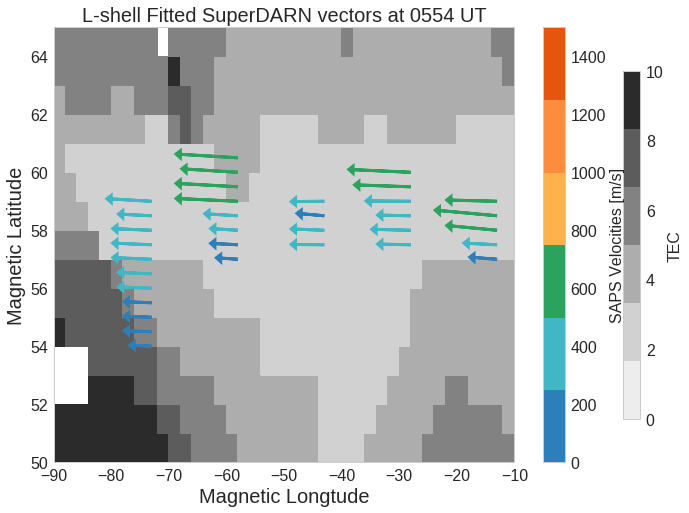

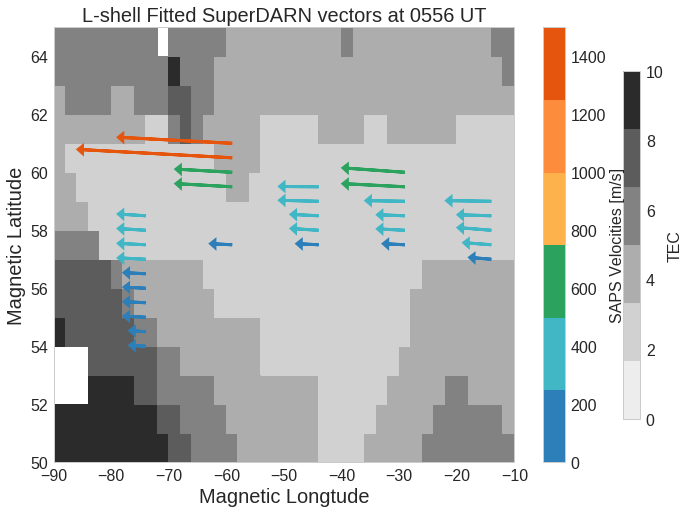

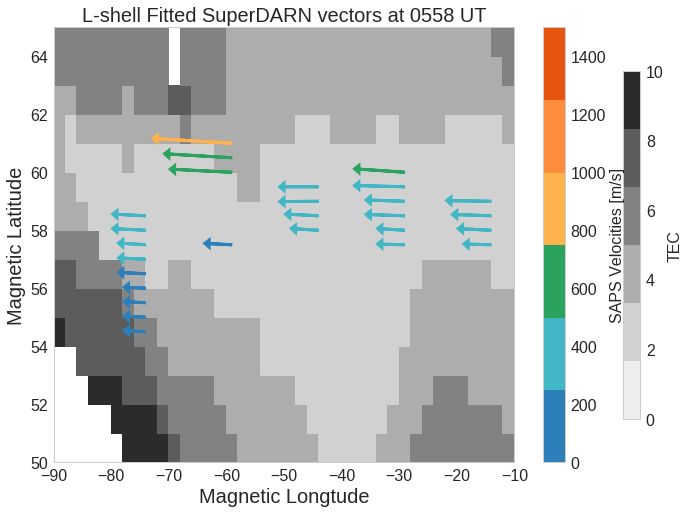

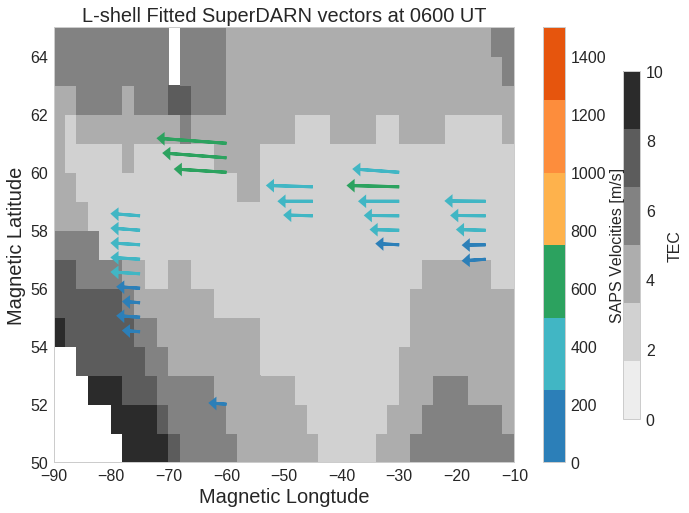

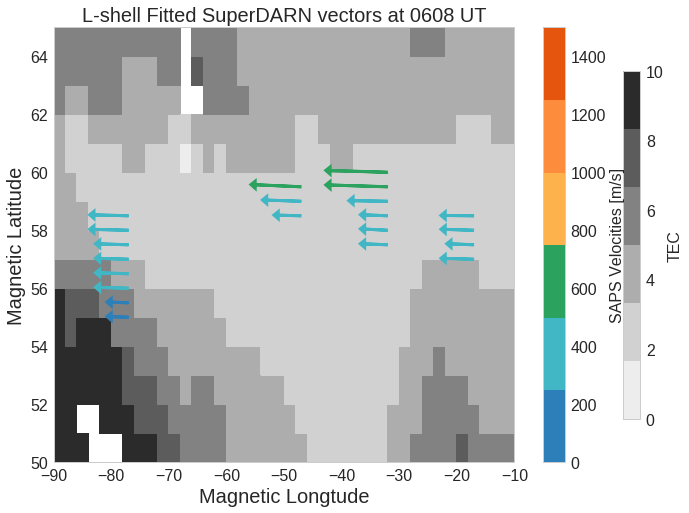

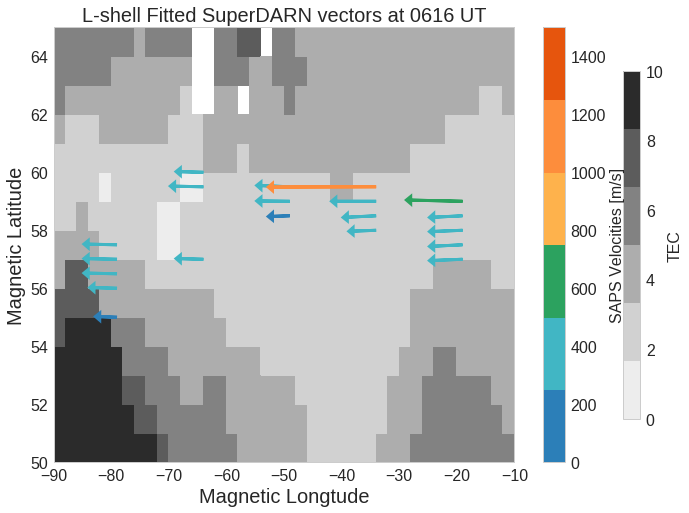

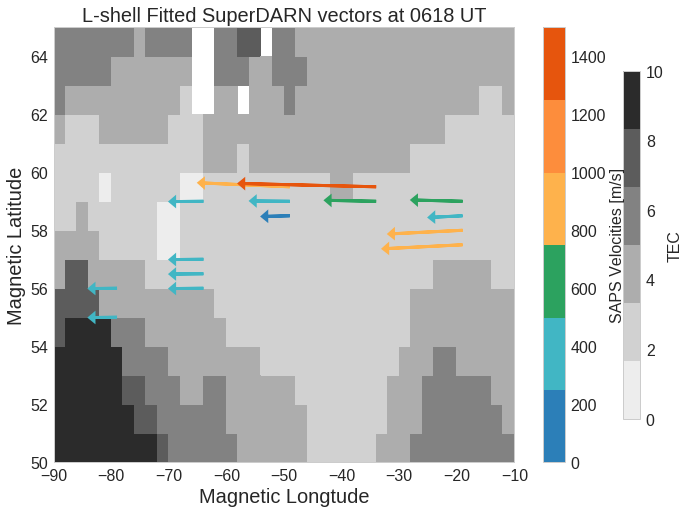

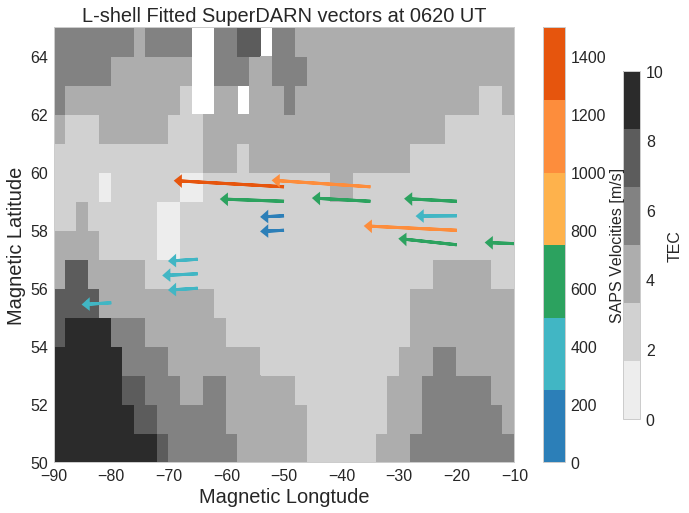

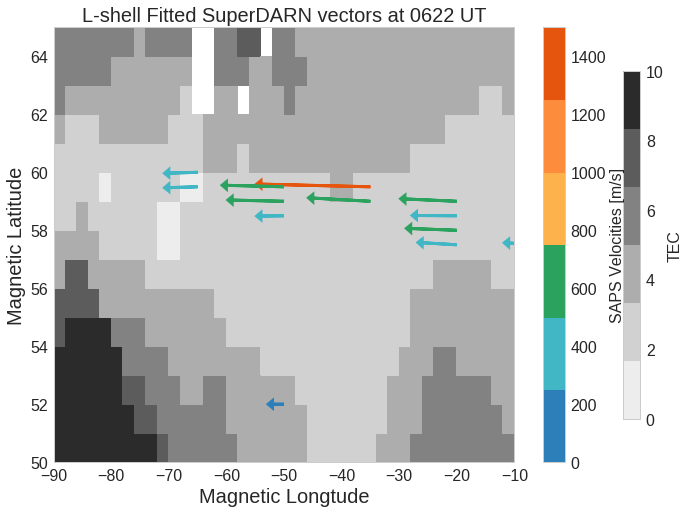

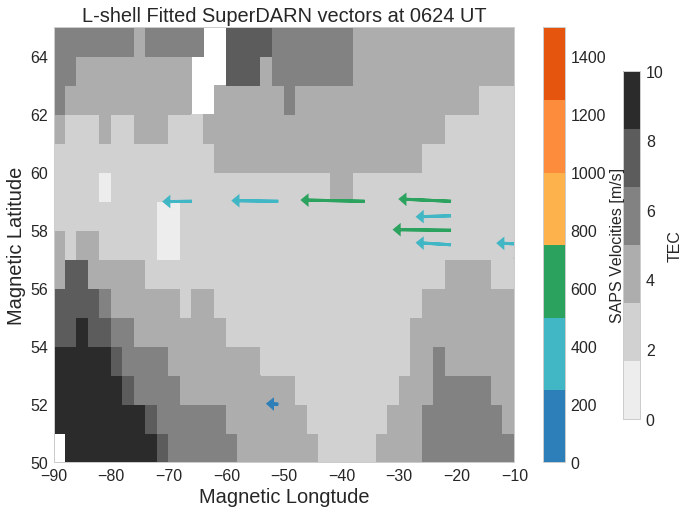

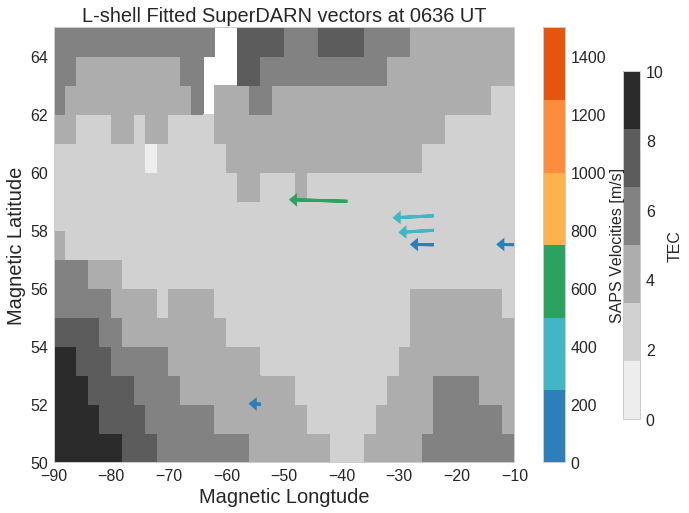

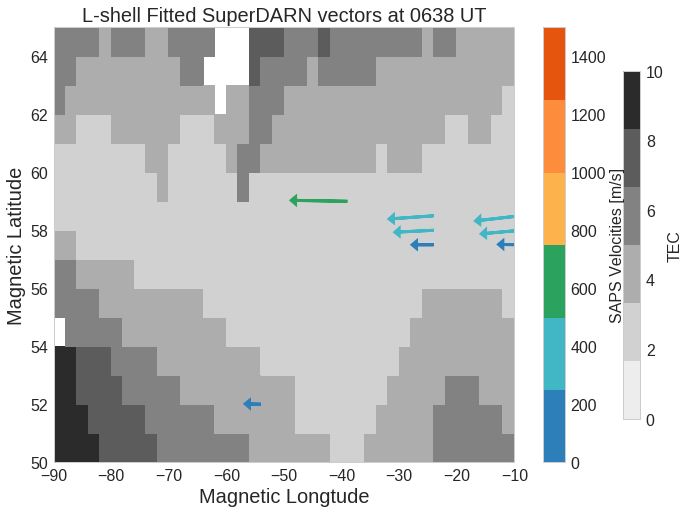

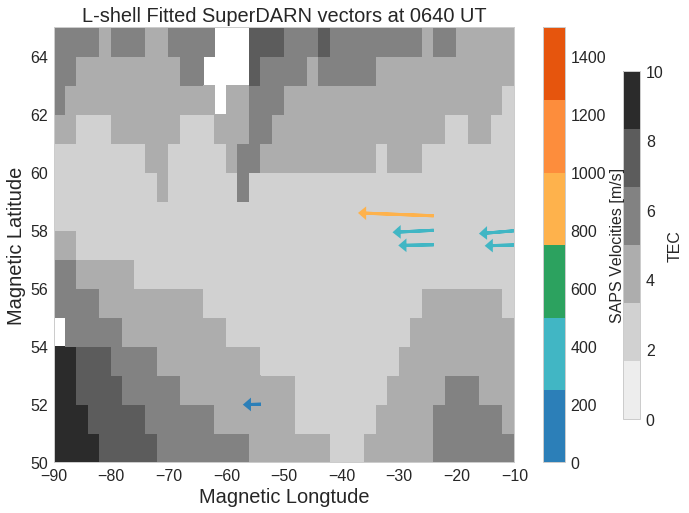

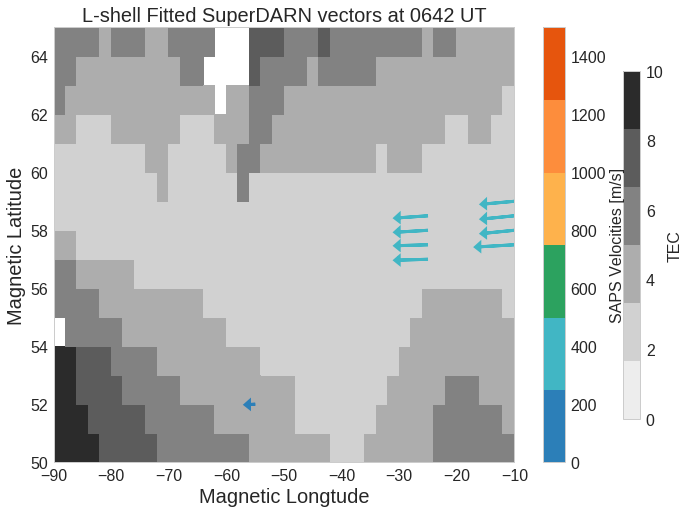

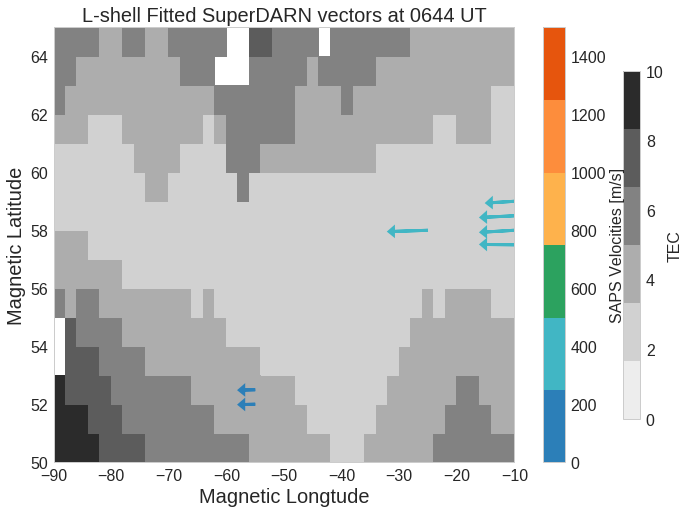

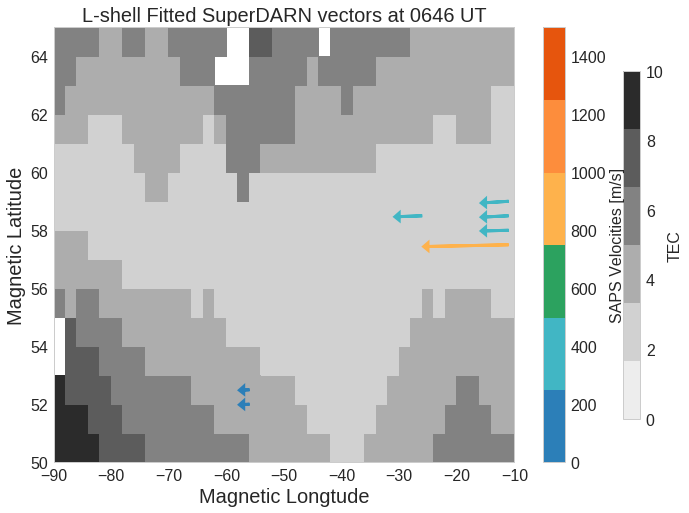

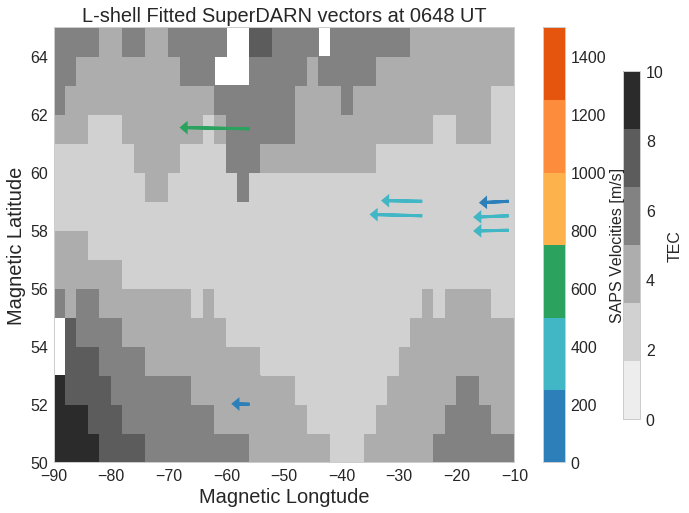

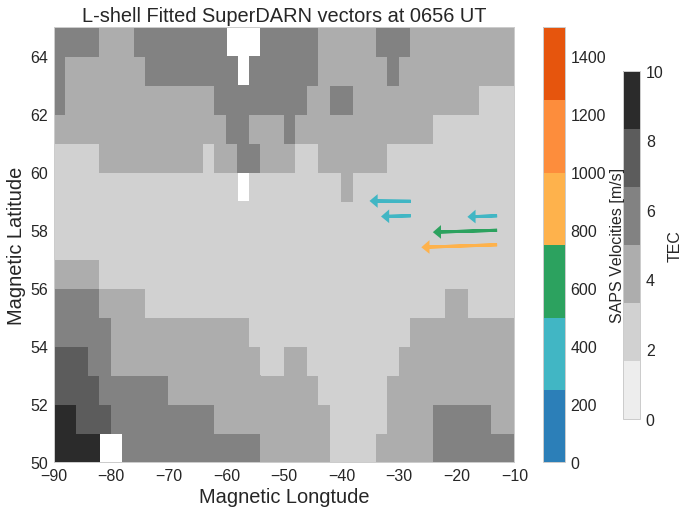

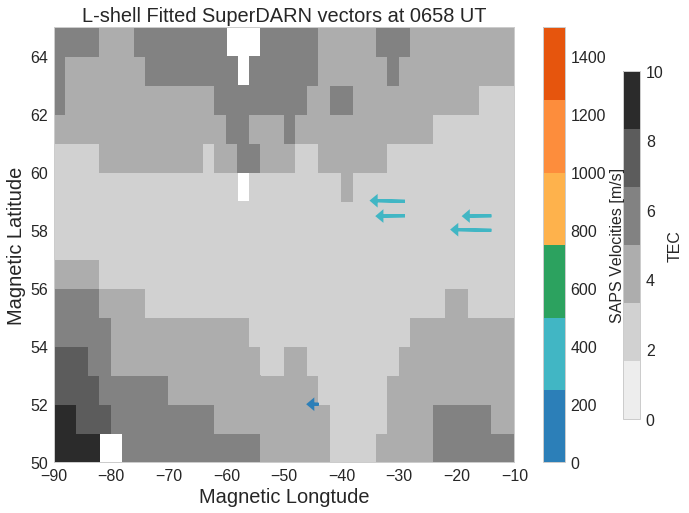

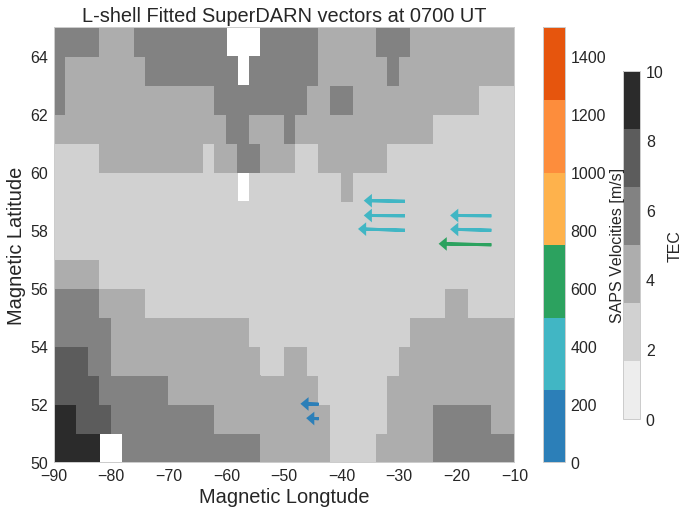

In [8]:
# # Make a movie
pdf_pages = PdfPages("../plots/sd-tec-movie.pdf")
currTime = timeStart

for currTime in lshellDF["date"].unique():
    selSapsDF = lshellDF[ lshellDF["date"] == currTime ]
    selSapsDF["SAPS speed [m/s]"] = selSapsDF["velSAPS"]
    plotMLTends = selSapsDF['EndptMlon'].tolist()
    plotmlatends = selSapsDF['endPtmlat'].tolist()
    plotMLTbegins = selSapsDF['Mlon'].tolist()
    plotmlatbegins = selSapsDF['mlat'].tolist()
    plotVelMagns = selSapsDF['SAPS speed [m/s]'].tolist()


    # Seaborn styling# OrRd
    sns.set_style("whitegrid")
    sns.set_context("paper")
    f = plt.figure(figsize=(12, 8))
    ax = f.add_subplot(1,1,1)
    # set colorbar
    tecSeaMap = ListedColormap(sns.color_palette("Greys"))
    colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
    seaMap = ListedColormap(sns.color_palette(colors))
    # lshlPlt = selSapsDF.plot( kind='scatter',
    #               x='Mlon',
    #               y='mlat',
    #               c='SAPS speed [m/s]',
    #               s=1., cmap=seaMap, vmin=velMagnScale[0],\
    #               vmax=velMagnScale[1], ax=ax,fontsize=20)
    lshellPlot = ax.scatter( x=selSapsDF["Mlon"], y=selSapsDF["mlat"],\
                         c=selSapsDF["SAPS speed [m/s]"],cmap=seaMap,\
                         vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

    colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
    for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
            zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
            # get a appropriate color for each bar
            currCol = seaMap( colNorm(currVel) )
    #         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
            ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                     head_width=0.25, head_length=0.75, fc=currCol, ec=currCol, lw=3.)
    # PLOT TEC Values
    # get the closest times where we have TEC data
    minDT = 1e3
    closestDate = None
    for tt in tecDF["date"].unique():
        ts = (tt - numpy.datetime64('1970-01-01T00:00:00Z')) / numpy.timedelta64(1, 's')
        dt = datetime.datetime.utcfromtimestamp(ts)
        cts = (currTime - numpy.datetime64('1970-01-01T00:00:00Z')) / numpy.timedelta64(1, 's')
        ct = datetime.datetime.utcfromtimestamp(cts)
        delDT = (dt-ct).total_seconds()
        if abs(delDT) < abs(minDT):
            closestDate = tt
            minDT = delDT
#     print "currTime---->", currTime, closestDate
    selTecDF = tecDF[ tecDF["date"] == closestDate ].reset_index(drop=True)
    selTecDF["Mlon2"] = [x-360 if x>180 else x for x in selTecDF["Mlon"] ]
    plotTecDF = selTecDF[ ["Mlon2", "Mlat",\
                            "med_tec"] ].pivot( "Mlon2", "Mlat" )

    mltVals = plotTecDF.index.values
    mlatVals = plotTecDF.columns.levels[1].values

    mltCntr, mlatCntr  = numpy.meshgrid( mltVals, mlatVals )
    # Mask the nan values! pcolormesh can't handle them well!
    medFTecVals = numpy.ma.masked_where(\
                    numpy.isnan(plotTecDF["med_tec"].values),\
                    plotTecDF["med_tec"].values)
    tecPlot = ax.pcolormesh(mltCntr.T , mlatCntr.T, medFTecVals,\
                            cmap=tecSeaMap, vmin=tecScale[0],\
                            vmax=tecScale[1])

    cbar = plt.colorbar(tecPlot, orientation='vertical',\
                        shrink=0.8, pad=-0.01)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel('TEC', fontsize=16)
    # PLOT TEC Values

    ax.set_xlim( [-90,-10] )
    ax.set_ylim( [ 50., 65. ] )
    ax.set_ylabel( "Magnetic Latitude", fontsize=20 )
    ax.set_xlabel( "Magnetic Longtude", fontsize=20 )
    ax.set_title("L-shell Fitted SuperDARN vectors at " +\
                 ct.strftime("%H%M") + " UT", fontsize=20)

    ax.tick_params(labelsize=16)
    cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
    cb.ax.tick_params(labelsize=16)
    cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)
    # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    # fig.colorbar(lshellPlot, cax=cax, orientation='horizontal')
    pdf_pages.savefig(f)
pdf_pages.close()

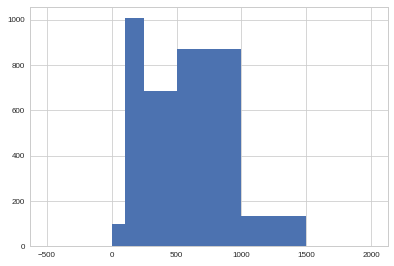

In [9]:
lshellDF["velSAPS"].hist(bins=[-500,0,100,250,500,1000,1500,2000])